# 1/Import Libraries


In [1]:
# plotting data
library(ggplot2)

# handling time series data
library(tseries)
library(forecast)
library(timeSeries)

# handling data
library(dplyr)

# handling dates
library(plyr)

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Loading required package: timeDate


Attaching package: ‘dplyr’


The following objects are masked from ‘package:timeSeries’:

    filter, lag


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: ‘plyr’


The following objects are masked from ‘package:dplyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize




# 2/ Import Data

In [2]:
train <- read.csv('../input/u-j-time-series-forecasting-case-study/train.csv')
test <- read.csv('../input/u-j-time-series-forecasting-case-study/test.csv')
sample <- read.csv('../input/u-j-time-series-forecasting-case-study/sample_submission.csv')
hl <- read.csv('../input/u-j-time-series-forecasting-case-study/holidays.csv')

# 3/ Check Data

In [3]:
head(train)

,date,transactions
,<chr>,<int>
1,01-01-2013,770
2,02-01-2013,93215
3,03-01-2013,78504
4,04-01-2013,78494
5,05-01-2013,93573
6,06-01-2013,90464


In [4]:
tail(train)

,date,transactions
,<chr>,<int>
1450,26-12-2016,105524
1451,27-12-2016,95643
1452,28-12-2016,103717
1453,29-12-2016,102665
1454,30-12-2016,127771
1455,31-12-2016,135568


In [5]:
head(test)

,date,id
,<chr>,<int>
1,01-01-2017,0
2,02-01-2017,1
3,03-01-2017,2
4,04-01-2017,3
5,05-01-2017,4
6,06-01-2017,5


In [6]:
tail(test)

,date,id
,<chr>,<int>
222,10-08-2017,221
223,11-08-2017,222
224,12-08-2017,223
225,13-08-2017,224
226,14-08-2017,225
227,15-08-2017,226


In [7]:
head(hl)

,Date,Holidays
,<chr>,<int>
1,02-03-2012,1
2,01-04-2012,1
3,12-04-2012,1
4,14-04-2012,1
5,21-04-2012,1
6,12-05-2012,1


In [8]:
tail(hl)

,Date,Holidays
,<chr>,<int>
307,21-12-2017,1
308,22-12-2017,2
309,23-12-2017,1
310,24-12-2017,1
311,25-12-2017,1
312,26-12-2017,1


# 4/ Basic Data Sanity

In [9]:
head(train$date)

[1] "01-01-2013" "02-01-2013" "03-01-2013" "04-01-2013" "05-01-2013"
[6] "06-01-2013"

In [10]:
# Convert date in proper format
train$date<-as.Date(train$date, format="%d-%m-%Y")
head(train$date)

[1] "2013-01-01" "2013-01-02" "2013-01-03" "2013-01-04" "2013-01-05"
[6] "2013-01-06"

In [11]:
# Checking for NA
colSums(is.na(train))

date transactions 
           0            0

In [12]:
# Counting number of days in each year
TotalDays = data.frame(train$date, year = strftime(train$date, "%Y"))
count(TotalDays, "year")

year,freq
<chr>,<int>
2013,364
2014,364
2015,364
2016,363


In [13]:
# Finding missing days in train dataset
date_range <- seq(min(train$date), max(train$date), by = 1) 
MissingDays<-date_range[!date_range %in% train$date] 
MissingDays

[1] "2013-12-25" "2014-12-25" "2015-12-25" "2016-01-01" "2016-01-03"
[6] "2016-12-25"

In [14]:
# Create data frame of missing values with 0
MissingDaysDF <- data.frame(MissingDays,as.integer(0))
colnames(MissingDaysDF) <- c("date", "transactions")
MissingDaysDF

date,transactions
<date>,<int>
2013-12-25,0
2014-12-25,0
2015-12-25,0
2016-01-01,0
2016-01-03,0
2016-12-25,0


In [15]:
# Find average of 1 Jan from previous years
Find_1JanValues <- train %>% filter(train$date == c('2013-01-01','2014-01-01','2015-01-01'))
mean(Find_1JanValues$transactions)

[1] 1433

In [16]:
# Update value for 2016-01-01 in MissingDaysDF
MissingDaysDF$transactions[MissingDaysDF$date == '2016-01-01'] <- 1433
MissingDaysDF

date,transactions
<date>,<dbl>
2013-12-25,0
2014-12-25,0
2015-12-25,0
2016-01-01,1433
2016-01-03,0
2016-12-25,0


In [17]:
# Find average of 3 Jan from previous years
Jan3_2013 <-train %>% filter(train$date == '2013-01-03')
Jan3_2014 <-train %>% filter(train$date == '2014-01-03')
Jan3_2015 <-train %>% filter(train$date == '2015-01-03')
round((Jan3_2013$transactions+Jan3_2014$transactions+Jan3_2015$transactions)/3,0)

[1] 86427

In [18]:
# Update value for 2016-01-03 in MissingDaysDF
MissingDaysDF$transactions[MissingDaysDF$date == '2016-01-03'] <- 86427
MissingDaysDF

date,transactions
<date>,<dbl>
2013-12-25,0
2014-12-25,0
2015-12-25,0
2016-01-01,1433
2016-01-03,86427
2016-12-25,0


In [19]:
# Create new train dataset with missing days
MissingDaysDF$transactions<-as.integer(MissingDaysDF$transactions)
train1<-rbind(train, MissingDaysDF)
train1<-train1[order(train1$date, decreasing = FALSE), ]
head(train1,n=10)
tail(train1,n=10)

,date,transactions
,<date>,<int>
1,2013-01-01,770
2,2013-01-02,93215
3,2013-01-03,78504
4,2013-01-04,78494
5,2013-01-05,93573
6,2013-01-06,90464
7,2013-01-07,75597
8,2013-01-08,72325
9,2013-01-09,71971


,date,transactions
,<date>,<int>
1447,2016-12-22,138892
1448,2016-12-23,156932
1449,2016-12-24,167542
1461,2016-12-25,0
1450,2016-12-26,105524
1451,2016-12-27,95643
1452,2016-12-28,103717
1453,2016-12-29,102665
1454,2016-12-30,127771


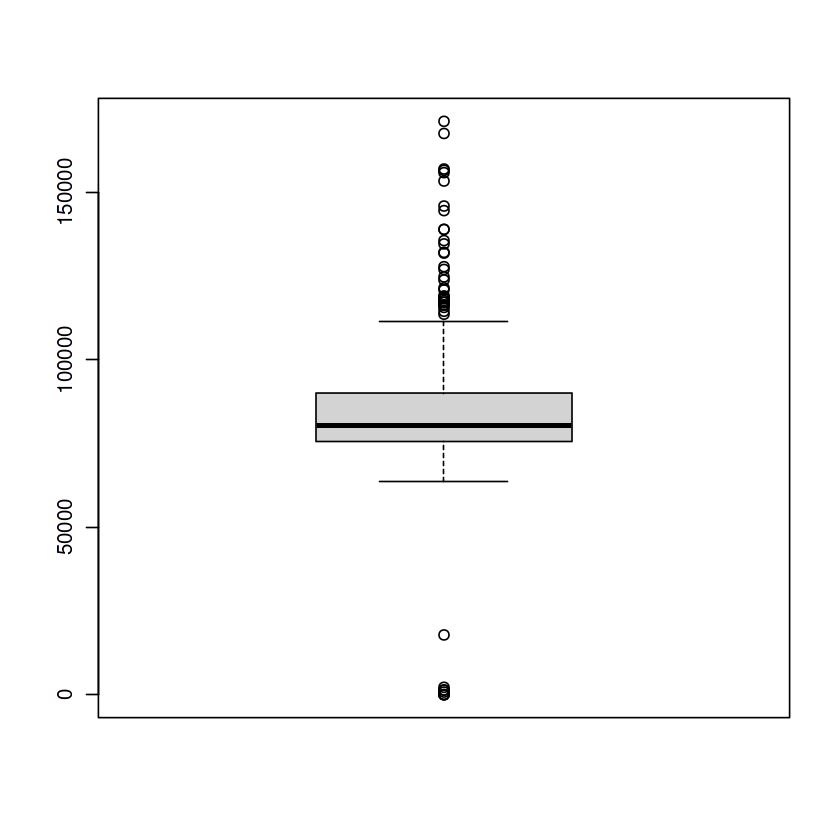

In [20]:
boxplot(train1$transactions)

Warning message in guerrero(x, lower, upper):
“Guerrero's method for selecting a Box-Cox parameter (lambda) is given for strictly positive data.”


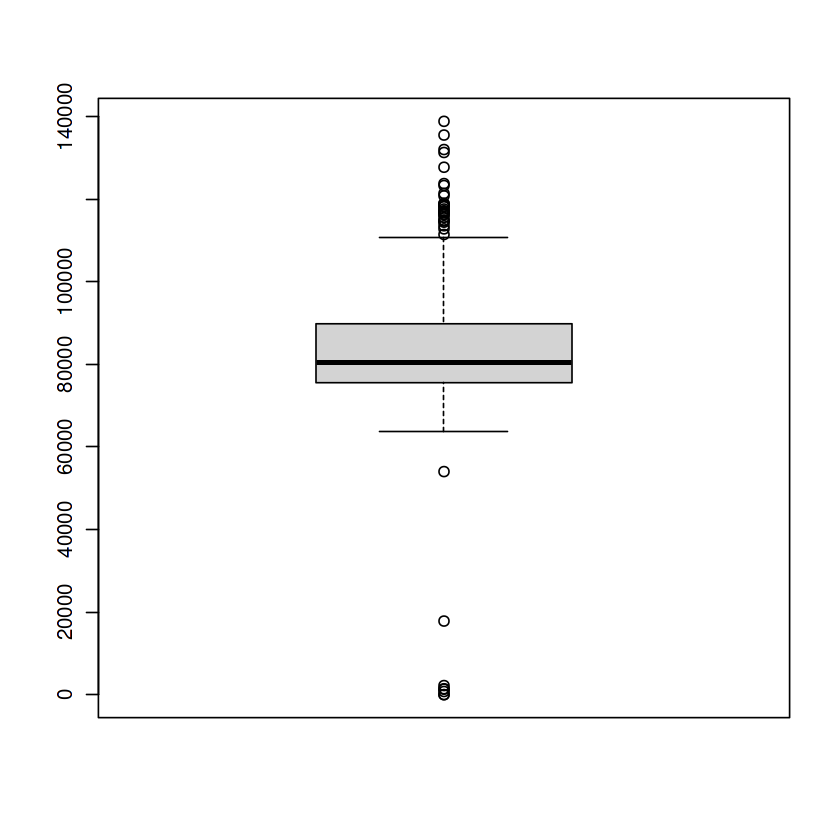

In [21]:
# Clean time series data for outliers in time series data
train1$transactions<-tsclean(train1$transactions, replace.missing = TRUE, iterate = 2, lambda = "auto")
boxplot(train1$transactions)

In [22]:
# Convert date in proper format for holidays list
hl$Date<-as.Date(hl$Date, format="%d-%m-%Y")
colnames(hl) <- c("date", "Holidays")
head(hl)

,date,Holidays
,<date>,<int>
1,2012-03-02,1
2,2012-04-01,1
3,2012-04-12,1
4,2012-04-14,1
5,2012-04-21,1
6,2012-05-12,1


In [23]:
# Create new variable 'Holidays' to identify days with holidays for all rows in train
train2 <- left_join(train1,hl,by='date')
train2$Holidays[is.na(train2$Holidays)] <- 0
head(train2)

,date,transactions,Holidays
,<date>,<dbl>,<dbl>
1,2013-01-01,770,1
2,2013-01-02,93215,0
3,2013-01-03,78504,0
4,2013-01-04,78494,0
5,2013-01-05,93573,1
6,2013-01-06,90464,0


In [24]:
# Extract 'Holidays' variable separately
Holidays <- train2$Holidays
length(Holidays)

[1] 1461

# 5/ EDA - Plot Data

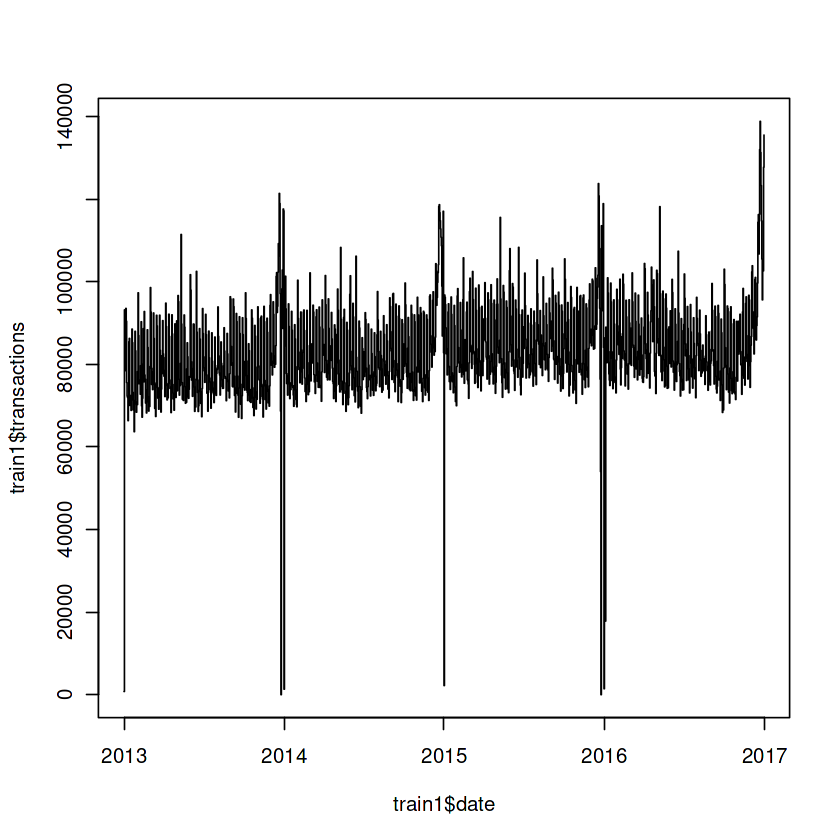

In [25]:
plot(train1$date,train1$transactions, type = "s")

# 5.1 Decomposition

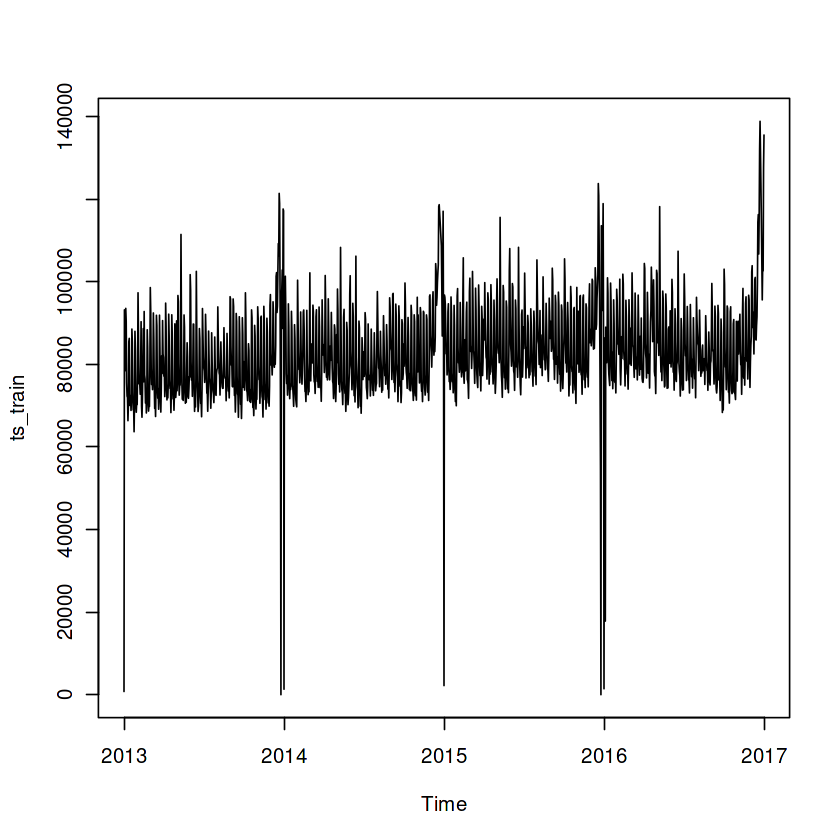

In [26]:
# Convert transactions to time series
ts_train <- ts(train1$transactions, frequency = 365, start = c(2013,1))
plot.ts(ts_train)

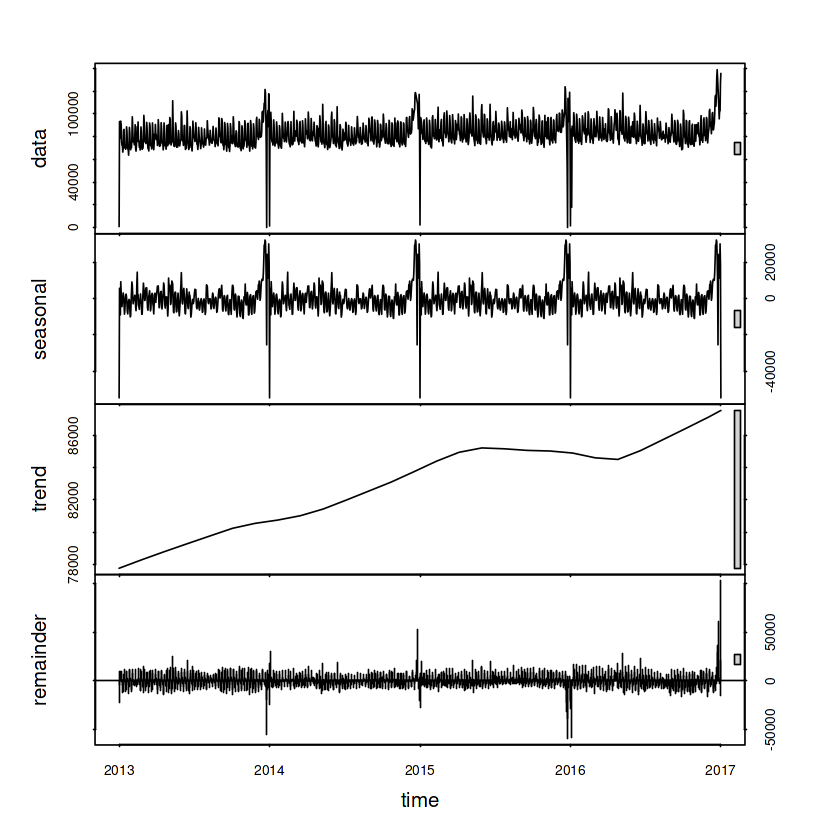

In [27]:
# Check STL of transactions
ts_train_stl<-stl(ts_train,s.window = "periodic")
plot(ts_train_stl)

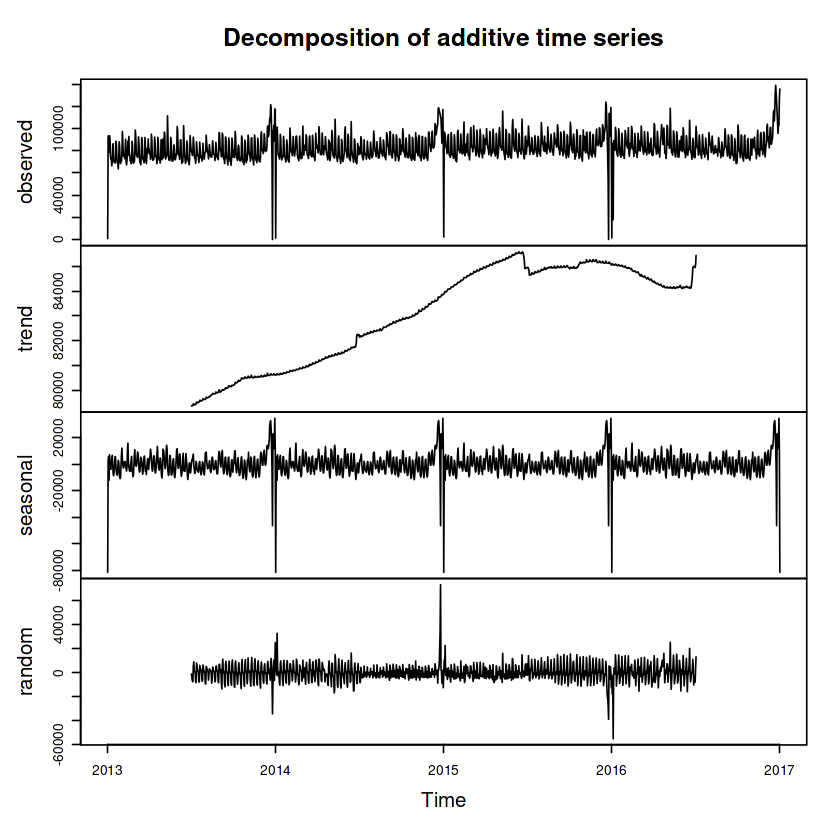

In [28]:
# Check decompose of transactions
ts_train_deco<-decompose(ts_train,type="additive")
plot(ts_train_deco)

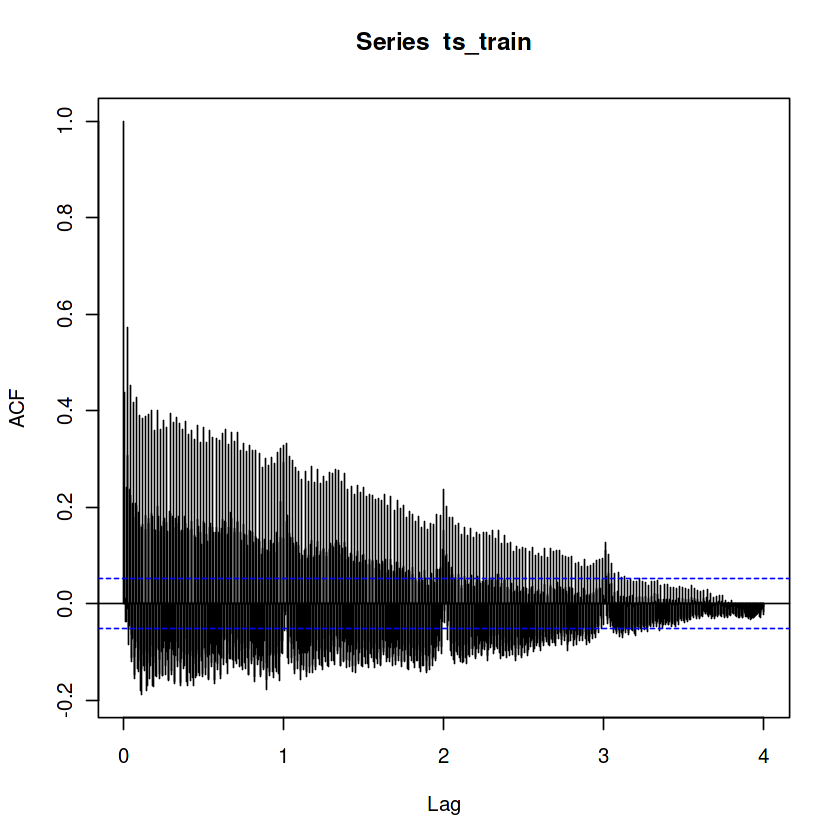

In [29]:
# Manual way to find q of MA, seems q is > 3
acf(ts_train, lag.max  = 1461)

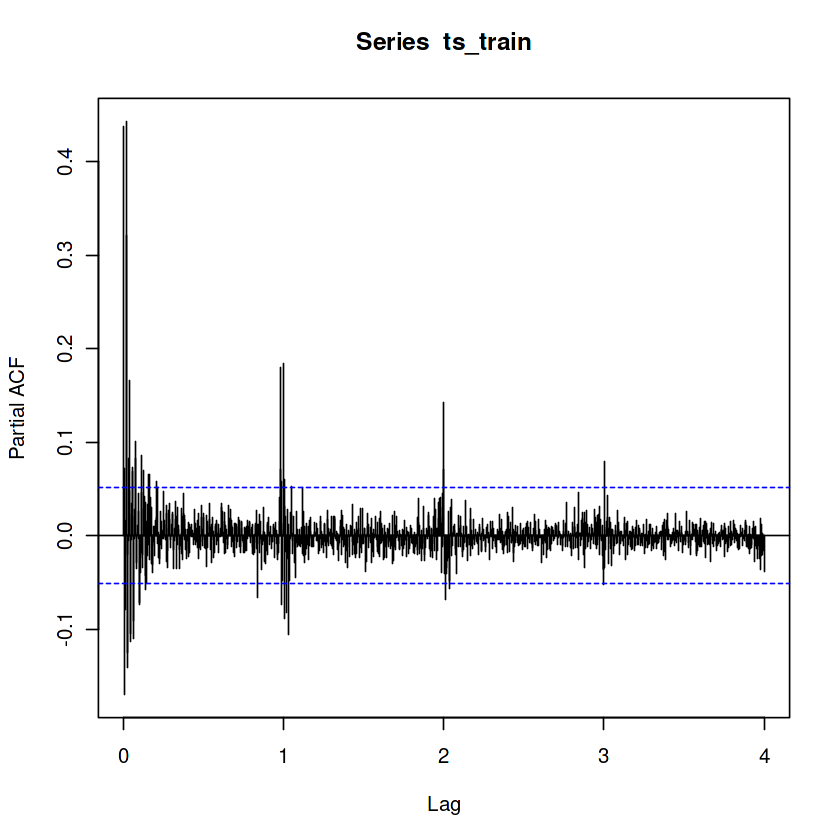

In [30]:
# Maunal way to find p of AR, seems p is > 3
pacf(ts_train, lag.max  = 1461)

# 5.2 ADF Test

In [31]:
# Stationarity test
adf.test(ts_train)
# data is stationary since p-values is < 0.01

Warning message in adf.test(ts_train):
“p-value smaller than printed p-value”



	Augmented Dickey-Fuller Test

data:  ts_train
Dickey-Fuller = -6.5234, Lag order = 11, p-value = 0.01
alternative hypothesis: stationary


# 6/ BUILD Forecasting Models

In [32]:
# Auto-ARIMA to automatically find p,d,q values, fitting holidays as well
modArima <- auto.arima(ts_train, xreg=Holidays)
modArima

Series: ts_train 
Regression with ARIMA(5,1,4) errors 

Coefficients:
         ar1      ar2      ar3      ar4      ar5      ma1      ma2     ma3
      0.0849  -0.2705  -0.6597  -0.1160  -0.4153  -0.6871  -0.0636  0.7489
s.e.  0.0661   0.0481   0.0553   0.0369   0.0457   0.0696   0.0660  0.0610
          ma4      xreg
      -0.5557  143.4362
s.e.   0.0385  492.9780

sigma^2 = 76959782:  log likelihood = -15324.3
AIC=30670.61   AICc=30670.79   BIC=30728.76

In [33]:
# ARIMA not considering seasonality, value of d is considered 0
fitcount <- arima(ts_train, order = c(5,0,4))

Warning message in arima(ts_train, order = c(5, 0, 4)):
“possible convergence problem: optim gave code = 1”


# 7/ Forecast

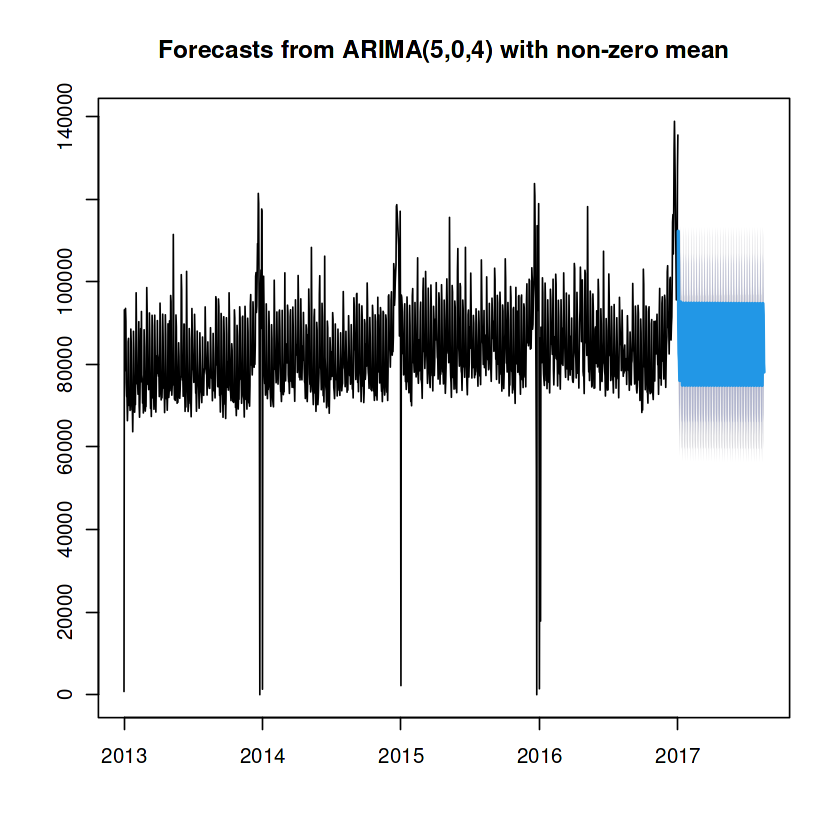

In [34]:
# forecasting using ARIMA model
forecastcount <- forecast(fitcount,227)   
plot(forecastcount)

In [35]:
# forecasting using other methods
train.mean <- meanf(ts_train,h=227)$mean
train.naive <- rwf(ts_train,h=227)$mean
train.drift <- rwf(ts_train,drift=TRUE,h=227)$mean
train.seas <- snaive(ts_train,h=227)$mean

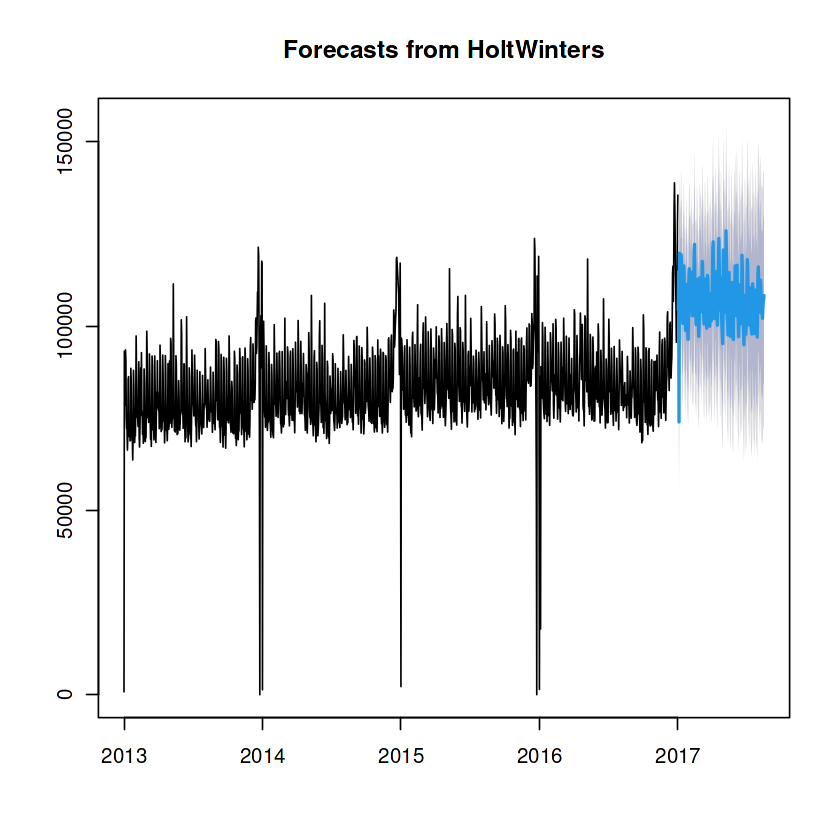

In [36]:
# forecasting using Holt Winters exponential smoothing model
hw_model<-HoltWinters(ts_train)
hw_forecast<-forecast(hw_model, h= 227) # forecast 10 period ahead
plot(hw_forecast)

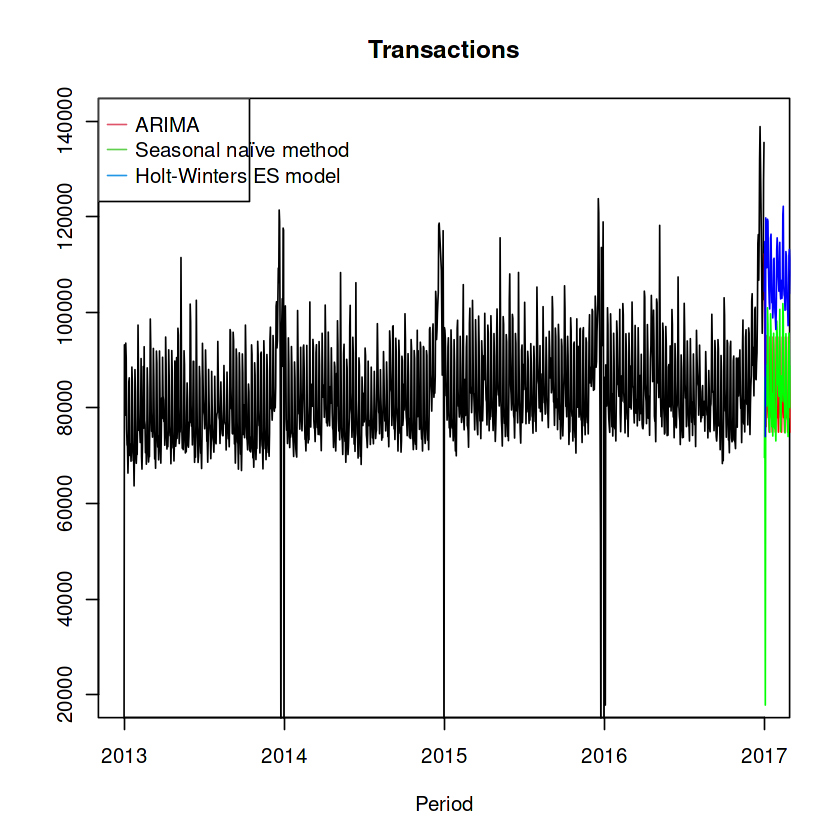

In [37]:
# plot the base Time series data
plot(ts_train, main="Transactions", ylab="", xlab="Period",ylim = c(20000,140000))

# plot forecasting of all models used
lines(forecastcount$mean, col='Red',)
lines(train.seas, col='Green')
lines(hw_forecast$mean, col='Blue')
legend("topleft",lty=1,bty=0,col=c(2,3,4),legend=c("ARIMA","Seasonal naïve method","Holt-Winters ES model"))
# "Seasonal naïve method" seems to be doing good job as per plot

# 8/ Check Performance

In [38]:
# Diagnosis
# ARIMA Model
accuracy(forecastcount$fitted,train1$transactions)

,ME,RMSE,MAE,MPE,MAPE
Test set,20.1918,8215.955,4256.987,-Inf,Inf


In [39]:
# MAPE
percentage_error <- abs((train1$transactions - forecastcount$fitted)/(train1$transactions))
mean(percentage_error)

[1] Inf

In [40]:
# SMAPE
# Custom function to calculate SMAPE
computeSmape <- function(actual, forecast) {
  return (1 / length(actual) * sum(2 * abs(forecast - actual) / (abs(actual)  + abs(forecast))))
}
# Determine SMAPE
computeSmape(train1$transactions,forecastcount$fitted)

[1] 0.05520575

In [41]:
# RMSE
sq_error<- (train1$transactions - forecastcount$fitted)^2
MSE <- mean(sq_error)
RMSE <- sqrt(MSE)
RMSE

[1] 8215.955

In [42]:
#RMSLE
RMSLE = sqrt(mean((log(forecastcount$fitted + 1) - log(train1$transactions + 1))^2))  
RMSLE

[1] 0.4741583

# 9/ Output / Submission

## Seasonal naïve Model

In [43]:
# Create Submission file for Seasonal naïve method Model
submission_snaive <- cbind(sample,round(train.seas,0))
submission_snaive <- subset(submission_snaive, select = -c(2))
colnames(submission_snaive) <- c("id", "transactions")
# Manually updating for unusual variance in predicted and actual 1 jan ['1' index] data compared to previous years, substitute the predicted value with mean
submission_snaive$transactions[submission_snaive$id == '0'] <- 1433
head(submission_snaive)
write.csv(submission_snaive,"submission.csv", row.names = FALSE, na = '0')

,id,transactions
,<int>,<dbl>
1,0,1433
2,1,86427
3,2,17829
4,3,89018
5,4,88846
6,5,80412
